# Capstone 2 - Lending Club Loan Paid or Charged Off Prediction
Sudha Kumar
11/10/2020

# Documentation

Documentation is the sixth step in the Data Science Method.  The following will be performed in this step:

1. Review the Results
2. Finalize Code
3. Finalize Documentation
4. Create a Project Report
5. Create a Slide Deck for the Executive Audience

In [1]:
#load python packages
import os
import pandas as pd
import pandas.api.types as ptypes
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings # For handling error messages.
#warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

# Best Model - Logistic Regression

In [2]:
# Read data output created in the EDA step
df = pd.read_csv("../EDA/data/Cap2_step3_output.csv", dtype={'verification_status_joint':object,'hardship_type':object, 'hardship_reason':object, 'hardship_status':object, 'hardship_loan_status':object, 'settlement_status':object}, index_col="Unnamed: 0")
df.head(5)

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_bal,...,initial_list_status,application_type,verification_status_joint,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_loan_status,debt_settlement_flag,settlement_status
0,2500,13.56,55000.0,18.24,0.0,1.0,0.0,45.0,1.0,4341,...,w,Individual,NaN,N,NaN,NaN,NaN,NaN,N,NaN
1,30000,18.94,90000.0,26.52,0.0,0.0,71.0,75.0,1.0,12315,...,w,Individual,NaN,N,NaN,NaN,NaN,NaN,N,NaN
2,5000,17.97,59280.0,10.51,0.0,0.0,0.0,0.0,0.0,4599,...,w,Individual,NaN,N,NaN,NaN,NaN,NaN,N,NaN
3,4000,18.94,92000.0,16.74,0.0,0.0,0.0,0.0,0.0,5468,...,w,Individual,NaN,N,NaN,NaN,NaN,NaN,N,NaN
4,30000,16.14,57250.0,26.35,0.0,0.0,0.0,0.0,0.0,829,...,w,Individual,NaN,N,NaN,NaN,NaN,NaN,N,NaN


In [3]:
df.shape

(2150627, 87)

In [4]:
# Drop unwanted columns
df_sel = df.drop(['total_pymnt','acc_now_delinq', 'delinq_amnt', 'tot_coll_amt', 'title', 'zip_code', 'addr_state', 'recoveries', 'debt_settlement_flag', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'settlement_status', 'last_pymnt_amnt'], axis=1)

In [5]:
# Drop irrelevant loan_status

df_sel.reset_index()
df_sel = df_sel[~(df_sel['loan_status'] == 'In Grace Period')]
df_sel = df_sel[~(df_sel['loan_status'] == 'Current')]
df_sel = df_sel[~(df_sel['loan_status'] == 'Late (31-120 days)')]
df_sel = df_sel[~(df_sel['loan_status'] == 'Default')]
df_sel = df_sel[~(df_sel['loan_status'] == 'Late (16-30 days)')]
df_sel.shape

(1250411, 73)

In [6]:
# Loan status:
# Setting '%Fully Paid' to 0
# Setting '%Charges Off' to 1

df_sel['loan_status'] = df_sel['loan_status'].replace(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'], '0')
df_sel['loan_status'] = df_sel['loan_status'].replace(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'], '1')

In [7]:
df_sel['loan_status'] = pd.to_numeric(df_sel['loan_status'])

In [8]:
# Create a list of object columns.  
cols_obj = []
for col in df_sel.columns:
    if df_sel[col].dtype == object:
        cols_obj.append(col)

In [9]:
df_sel = pd.concat([df_sel.drop(cols_obj, axis=1), pd.get_dummies(df_sel[cols_obj])], axis=1)
df_sel.head(5)

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_bal,...,hardship_reason_REDUCED_HOURS,hardship_reason_UNEMPLOYMENT,hardship_status_ACTIVE,hardship_status_BROKEN,hardship_status_COMPLETED,hardship_loan_status_Current,hardship_loan_status_In Grace Period,hardship_loan_status_Issued,hardship_loan_status_Late (16-30 days),hardship_loan_status_Late (31-120 days)
100,30000,22.35,100000.0,30.46,0.0,0.0,51.0,84.0,1.0,15603,...,0,0,0,0,0,0,0,0,0,0
152,40000,16.14,45000.0,50.53,0.0,0.0,0.0,0.0,0.0,34971,...,0,0,0,0,0,0,0,0,0,0
170,20000,7.56,100000.0,18.92,0.0,0.0,48.0,0.0,0.0,25416,...,0,0,0,0,0,0,0,0,0,0
186,4500,11.31,38500.0,4.64,0.0,0.0,25.0,0.0,0.0,4472,...,0,0,0,0,0,0,0,0,0,0
269,20000,17.97,57000.0,22.18,0.0,0.0,0.0,0.0,0.0,33356,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Using a sample size of 200,000 for modeling, due to Memory error when using all observations.
df_sample = df_sel.sample(200000)
df_sample.head()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_bal,...,hardship_reason_REDUCED_HOURS,hardship_reason_UNEMPLOYMENT,hardship_status_ACTIVE,hardship_status_BROKEN,hardship_status_COMPLETED,hardship_loan_status_Current,hardship_loan_status_In Grace Period,hardship_loan_status_Issued,hardship_loan_status_Late (16-30 days),hardship_loan_status_Late (31-120 days)
1970870,18000,10.15,76000.0,17.40,3.0,0.0,15.0,0.0,0.0,12780,...,0,0,0,0,0,0,0,0,0,0
1070667,18000,15.61,136000.0,33.25,0.0,1.0,68.0,0.0,0.0,32957,...,0,0,0,0,0,0,0,0,0,0
2054398,22400,9.67,100000.0,17.15,0.0,1.0,0.0,0.0,0.0,28461,...,0,0,0,0,0,0,0,0,0,0
1339590,30000,16.49,160000.0,16.76,0.0,1.0,0.0,0.0,0.0,22818,...,0,0,0,0,0,0,0,0,0,0
1335482,19775,16.49,63000.0,37.68,3.0,1.0,2.0,0.0,0.0,11977,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y = df_sample['loan_status']
X = df_sample.drop(['loan_status'], axis=1)

In [12]:
from sklearn.model_selection import train_test_split

y = y.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [13]:
from sklearn import preprocessing as ppg

scaler = ppg.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_train_scaled

array([[-1.19118730e+00, -2.76610628e-01, -1.17959581e+00, ...,
        -2.58199750e-03, -4.24646423e-02, -1.31667529e-02],
       [-3.61317997e-01,  9.57370013e-01, -6.00006314e-01, ...,
        -2.58199750e-03, -4.24646423e-02, -1.31667529e-02],
       [-9.53231947e-01, -1.34872328e+00, -1.24399464e+00, ...,
        -2.58199750e-03, -4.24646423e-02, -1.31667529e-02],
       ...,
       [-2.98854716e-01, -6.63924610e-02, -4.06809816e-01, ...,
        -2.58199750e-03, -4.24646423e-02, -1.31667529e-02],
       [ 1.17567158e-01, -6.97046963e-01, -2.78012150e-01, ...,
        -2.58199750e-03, -4.24646423e-02, -1.31667529e-02],
       [ 3.49573631e-01,  2.63280881e+00, -3.83658435e-01, ...,
        -2.58199750e-03, -4.24646423e-02, -1.31667529e-02]])

In [14]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[ 0.47450019,  0.68198421,  0.2049791 , ..., -0.002582  ,
        -0.04246464, -0.01316675],
       [-1.27744612, -1.48536509,  1.65395283, ..., -0.002582  ,
        -0.04246464, -0.01316675],
       [-0.47732123,  1.30843435, -0.7610034 , ..., -0.002582  ,
        -0.04246464, -0.01316675],
       ...,
       [-1.23877837, -0.39223062, -0.27801215, ..., -0.002582  ,
        -0.04246464, -0.01316675],
       [-1.25067614, -0.80215605, -0.95419989, ..., -0.002582  ,
        -0.04246464, -0.01316675],
       [ 0.11756716, -1.43281055, -0.27801215, ..., -0.002582  ,
        -0.04246464, -0.01316675]])

# Feature importance with Forest of Trees

In [15]:
X_train_scaled.shape

(150000, 139)

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest = forest.fit(X_train_scaled, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_scaled.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 1 (0.038970)
2. feature 12 (0.037950)
3. feature 3 (0.034871)
4. feature 0 (0.034489)
5. feature 2 (0.033758)
6. feature 10 (0.033104)
7. feature 9 (0.032743)
8. feature 28 (0.031179)
9. feature 42 (0.030931)
10. feature 17 (0.030268)
11. feature 27 (0.030237)
12. feature 41 (0.030174)
13. feature 24 (0.030008)
14. feature 31 (0.029697)
15. feature 43 (0.029052)
16. feature 38 (0.027787)
17. feature 5 (0.024048)
18. feature 6 (0.023151)
19. feature 37 (0.022711)
20. feature 32 (0.018412)
21. feature 14 (0.016005)
22. feature 23 (0.015525)
23. feature 30 (0.015277)
24. feature 4 (0.014913)
25. feature 33 (0.014162)
26. feature 22 (0.014042)
27. feature 21 (0.013119)
28. feature 26 (0.012579)
29. feature 7 (0.012438)
30. feature 20 (0.012347)
31. feature 19 (0.012005)
32. feature 18 (0.011800)
33. feature 59 (0.011310)
34. feature 25 (0.010795)
35. feature 58 (0.010681)
36. feature 8 (0.010192)
37. feature 60 (0.009690)
38. feature 109 (0.008995)
39. feature 3

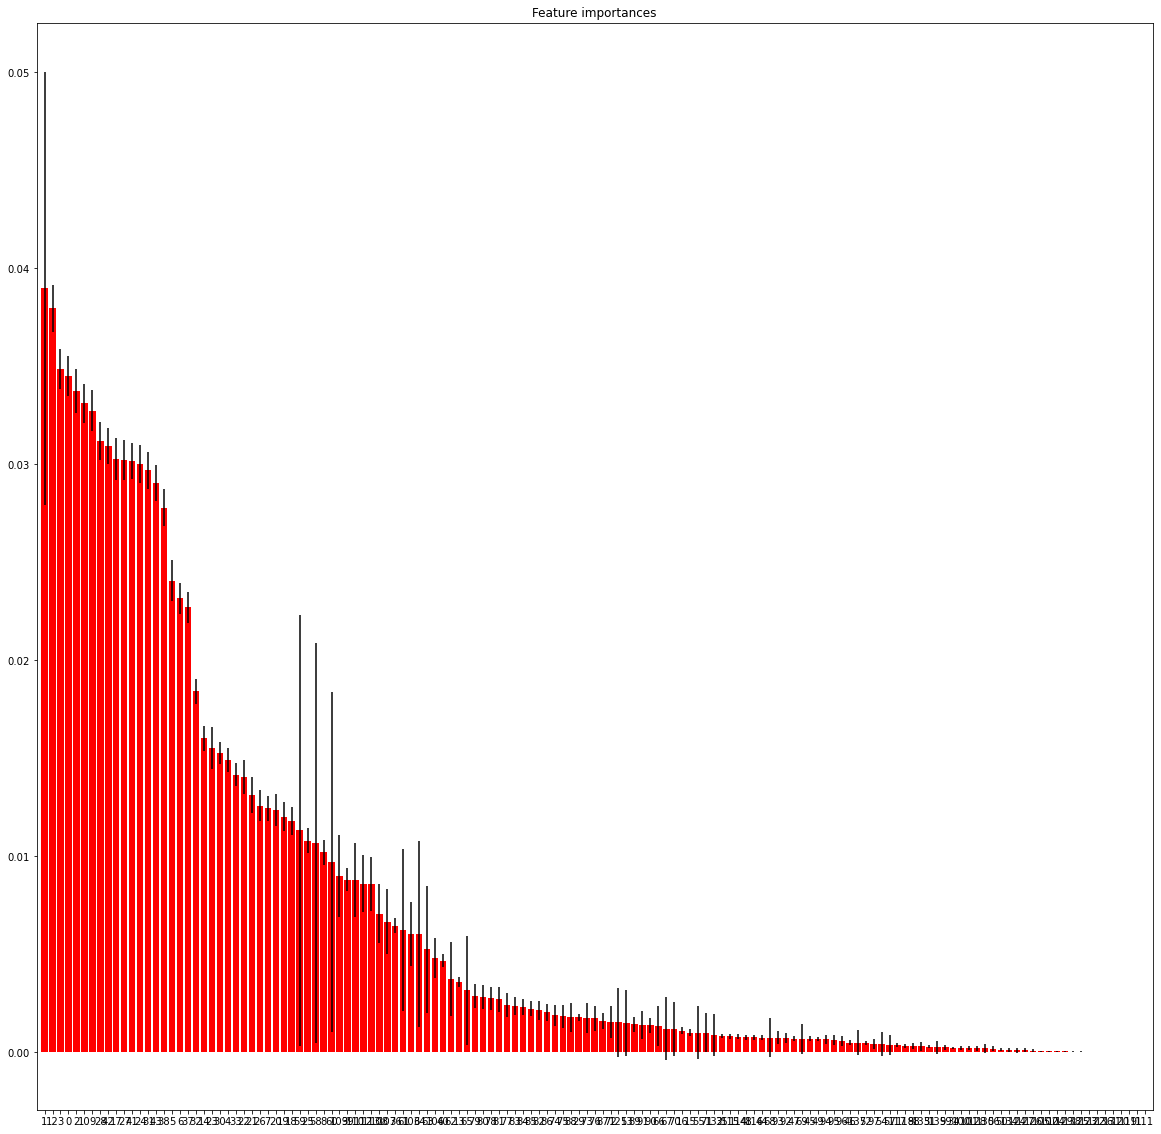

In [17]:
# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(20,20))
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

# Feature selection using SelectFromModel

In [51]:
# Feature selection based on the above feature importance
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(forest, prefit=True, threshold=0.01)
X_train_new = model.transform(X_train_scaled)
X_train_new.shape

(150000, 36)

In [52]:
X_test_new = model.transform(X_test_scaled)
X_test_new.shape

(50000, 36)

In [53]:
model.get_support(True)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 14, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 37, 38, 41, 42, 43,
       58, 59], dtype=int64)

In [54]:
X_cols = X_test.columns

In [55]:
print("Features selected by scikit learn SelecFromModel are:\n")
for i in model.get_support(True):
    print(X_cols[i])

Features selected by scikit learn SelecFromModel are:

loan_amnt
int_rate
annual_inc
dti
delinq_2yrs
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
pub_rec
revol_bal
revol_util
total_rec_int
mths_since_last_major_derog
tot_cur_bal
open_acc_6m
open_act_il
total_bal_il
il_util
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
inq_last_12m
avg_cur_bal
bc_util
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recent_revol_delinq
num_accts_ever_120_pd
pct_tl_nvr_dlq
percent_bc_gt_75
total_bal_ex_mort
total_bc_limit
total_il_high_credit_limit
term_ 36 months
term_ 60 months


In [56]:
# Using K fold cross validation and Grid search to get the most accurate prediction

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [10,20,30,40,50]}
clf = RandomForestClassifier(random_state = 1,n_jobs=-1)
clf_cv = GridSearchCV(clf, param_grid, cv=5)
clf_cv.fit(X_train_new, y_train)
y_pred_ranf = clf_cv.predict(X_test_new)
print("Tuned Random Forest Parameters: {}".format(clf_cv.best_params_)) 
print("Best score is {}".format(clf_cv.best_score_))
print("Accuracy score is {}".format(accuracy_score(y_test, y_pred_ranf)))

Tuned Random Forest Parameters: {'n_estimators': 50}
Best score is 0.8001466666666666
Accuracy score is 0.80004


# Review the results

In [57]:
from sklearn.metrics import confusion_matrix

pl_ranf = confusion_matrix(y_test,y_pred_ranf)
pl_ranf

array([[38847,   924],
       [ 9074,  1155]], dtype=int64)

In [58]:
np.bincount(y_pred_ranf)

array([47921,  2079], dtype=int64)

0 - Fully paid <br>
1 - Charges off

In [59]:
np.bincount(y_test)

array([39771, 10229], dtype=int64)

In [60]:
from sklearn.metrics import classification_report

cl_rep_ranf = classification_report(y_test,y_pred_ranf)
print(cl_rep_ranf)

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     39771
           1       0.56      0.11      0.19     10229

    accuracy                           0.80     50000
   macro avg       0.68      0.54      0.54     50000
weighted avg       0.76      0.80      0.74     50000



In [61]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

ac = accuracy_score(y_test, y_pred_ranf)
print('Test Data Set Random Forest: Accuracy=%.3f' % (ac))

f1 = f1_score(y_test, y_pred_ranf, average='weighted')
print('Test Data Set Random Forest: f1-score=%.3f' % (f1))

roc_auc = roc_auc_score(y_test, y_pred_ranf)
print('Test Data Set Random Forest: roc_auc_score=%.3f' % (roc_auc))

Test Data Set Random Forest: Accuracy=0.800
Test Data Set Random Forest: f1-score=0.743
Test Data Set Random Forest: roc_auc_score=0.545


# Random Forest Metrics for various Threshold values in feature selection

| Threshold | # Features selected | Accuracy| f1_score|roc_auc_score|
| --- | --- | --- | --- | --- |
|  0 | 139 | 0.801 | 0.740 | 0.541 |
| 0.001 | 83 | 0.801 | 0.741 | 0.542 |
| 0.005 | 49 | 0.799 | 0.739 | 0.540 |
| 0.01 | 36 | 0.800 | 0.743 | 0.545 |
| 0.018 | 20 | 0.799 | 0.735 | 0.535 |

# Figures for data story

ROC curve

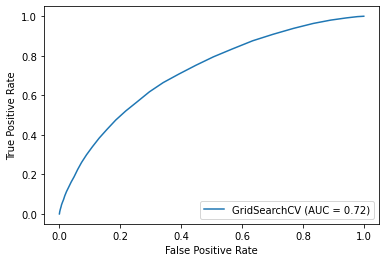

In [62]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf_cv, X_test_new, y_test)

# Finalize code

Save the model

In [63]:
import pickle
s = pickle.dumps(clf_cv)
from joblib import dump, load
dump(clf_cv, 'models/model_loan.joblib') 

['models/model_loan.joblib']

# Finalize documentation

In [64]:
clf_cv.cv_results_

{'mean_fit_time': array([ 3.1067112 ,  5.87327981,  8.81523275, 11.28422914, 14.20874562]),
 'std_fit_time': array([0.03671816, 0.14001859, 0.08955356, 0.09373458, 0.14521054]),
 'mean_score_time': array([0.13108182, 0.24548545, 0.25324903, 0.23652315, 0.36291175]),
 'std_score_time': array([0.00598295, 0.00723535, 0.01615311, 0.00415176, 0.01555881]),
 'param_n_estimators': masked_array(data=[10, 20, 30, 40, 50],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10},
  {'n_estimators': 20},
  {'n_estimators': 30},
  {'n_estimators': 40},
  {'n_estimators': 50}],
 'split0_test_score': array([0.79186667, 0.7966    , 0.79876667, 0.79973333, 0.8015    ]),
 'split1_test_score': array([0.79153333, 0.79533333, 0.79703333, 0.79833333, 0.79996667]),
 'split2_test_score': array([0.7917    , 0.79766667, 0.7997    , 0.7991    , 0.8002    ]),
 'split3_test_score': array([0.79103333, 0.79426667, 0.79773333, 0.798

In [65]:
clf_cv.best_params_

{'n_estimators': 50}

In [66]:
clf_cv.best_score_

0.8001466666666666

In [67]:
clf_cv.best_index_

4

In [68]:
results_df = pd.DataFrame(clf_cv.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.106711,0.036718,0.131082,0.005983,10,{'n_estimators': 10},0.791867,0.791533,0.791700,0.791033,0.788633,0.790953,0.001193,5
1,5.873280,0.140019,0.245485,0.007235,20,{'n_estimators': 20},0.796600,0.795333,0.797667,0.794267,0.794567,0.795687,0.001277,4
2,8.815233,0.089554,0.253249,0.016153,30,{'n_estimators': 30},0.798767,0.797033,0.799700,0.797733,0.796400,0.797927,0.001185,3
3,11.284229,0.093735,0.236523,0.004152,40,{'n_estimators': 40},0.799733,0.798333,0.799100,0.798667,0.799233,0.799013,0.000481,2
4,14.208746,0.145211,0.362912,0.015559,50,{'n_estimators': 50},0.801500,0.799967,0.800200,0.798567,0.800500,0.800147,0.000947,1


Save model results

In [69]:
results_df.to_csv('models/model_results.csv')